**Matrix completion using trace norm regularization**

This shows the use of Douglas-Rachford's algorithm to perform matrix completion with trace norm (nuclear norm) regularization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

We consider $n \times n$ matrices.

In [ ]:
n = 100

Generate a rank $r$ random matrix.

In [ ]:
r = 10
x0 = np.dot(np.random.randn(n,r),np.random.randn(r,n))

Display the singular values.

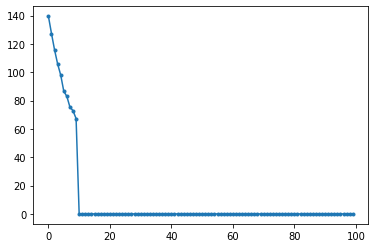

In [ ]:
plt.plot(np.linalg.svd(x0)[1], '.-')

Random selection of $p$ indices.

In [ ]:
def indices(n,p): return np.random.permutation(n**2)[0:p]

Associated forward (measurement) operator $\Phi$ and its adjoint $\Phi^\top$.

In [ ]:
def phi(x,I): return x.flatten()[I]
def phi_adj(y,I):
  x = np.zeros(n**2)
  x[I] = y
  return x.reshape((n,n))
def dotp(x,y): return np.sum( x.flatten()*y.flatten() )

Check adjointness of $\Phi$ and $\Phi^\top$.

In [ ]:
p = 12
x = np.random.randn(n,n)
y = np.random.randn(p)
I = indices(n,p)
# must be 0
print( dotp(y,phi(x,I)) - dotp(phi_adj(y,I),x) )

-8.881784197001252e-16


Define the proximal operator of $F(x) = \iota_{\Phi \cdot = y}(x)$ (ie the ortho-projector).



In [ ]:
def prox_F(x,y,I):  return x+phi_adj(y-phi(x,I),I)

Check that prox$_F \circ$ prox$_F$ = prox$_F$ (since it is a projector).

In [ ]:
x1 = prox_F(x,y,I)
print( np.linalg.norm(x1-prox_F(x1,y,I)) )

2.1677797545656835e-16


Compute the proximal operator of $G(x):=\|x\|_*$ the nuclear norm, which is the soft-thesholding of the singular values.

In [ ]:
def soft_thresholding(x, u): return np.minimum(x+u, np.maximum(0,x-u))

Displays the soft thresholding.

In [1]:
t = np.linspace(-3,3,1000)
plt.plot(t, soft_thresholding(t,1.1));

NameError: ignored

In [ ]:
def prox_G(x, gamma): 
    u,s,vh = np.linalg.svd(x)
    soft_s=soft_thresholding(s,gamma)
    return (u*soft_s)@vh

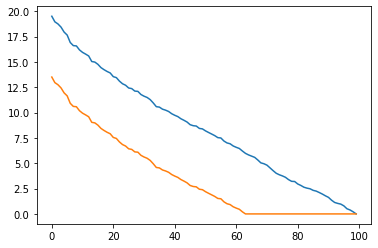

In [ ]:
_,a,_ = np.linalg.svd(x)
_,b,_ = np.linalg.svd(prox_G(x,6))
plt.plot(a)
plt.plot(b);

Compute the symmetrized proximal operator (rprox).

In [ ]:
def rprox_F(x,gamma,y,I):
    return 2*prox_F(x,y,I)-x
def rprox_G(x,gamma):
    return 2*prox_G(x,gamma)-x

In [ ]:
def n_norm(x): return np.linalg.norm(x,'nuc')

Douglas-Rachford's algorithm. 

In [ ]:
def DR(y, mu, gamma,n_iter,I): 
    x_t = np.zeros((n,n))
    x_list = []
    x_t_list = []
    nucl_norm=[]
    for i in range(n_iter):
        x_t_list.append(x_t.copy())
        x_t=(1-mu/2)*x_t+mu/2*rprox_G(rprox_F(x_t,gamma,y,I),gamma)
        x=prox_F(x_t,y,I)
        x_list.append(x.copy())
        nucl_norm.append(n_norm(x))
    return x, nucl_norm 

Test the DR algorithm.

In [ ]:
mu = 1
gamma = 1
p = int( .5*n*n )
I = indices(n,p)
x,nucl_norm = DR(phi(x0,I), mu, gamma, 500, I )

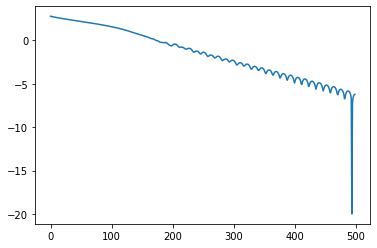

In [ ]:
plt.plot(np.log10( nucl_norm-np.min(nucl_norm)+1e-20 ))

Test with varying number $p$ of measurements.

In [ ]:
r = 4
x0 = np.random.randn(n,r) @ np.random.randn(r,n)
# we varie p
n_test = 10 # number of tests
p_list = np.round( np.linspace(.02,.5,n_test)*n**2 )
err = []
n_iter = 500
import progressbar
for i in progressbar.progressbar(range(n_test)):
  p = int( p_list[i] )
  I = indices(n,p)
  y = phi(x0,I)
  x,nucl_norm = DR(y, mu, gamma, n_iter, I )
  err.append( np.linalg.norm(x-x0) )

100% (10 of 10) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


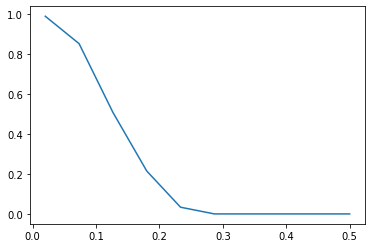

In [ ]:
plt.plot(p_list/(n**2), err/np.linalg.norm(x0));